In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
#from qiskit_aer.noise import NoiseModel
#from qiskit_ibm_runtime import QiskitRuntimeService
#from qiskit.primitives import BackendSamplerV2
import numpy as np

In [2]:
backend= AerSimulator()

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np

backend = AerSimulator()

def measure_in_basis(circuit, final_target, base, shots=1024):
    """
    Mede o qubit final na base especificada (X, Y ou Z) e retorna o valor esperado
    e o dicionário de contagens. Extraímos o token do registrador de tomografia
    a partir das chaves de counts (como '0 10' etc).
    """
    circ = circuit.copy()
    
    # Registrador clássico apenas para tomografia (1 bit)
    c_temp = ClassicalRegister(1, 'c_temp')
    circ.add_register(c_temp)

    # Rotação de base
    if base == 'X':
        circ.h(final_target)
    elif base == 'Y':
        circ.sdg(final_target)
        circ.h(final_target)
    # se base == 'Z' não faz nada

    # Mede o qubit final no registrador temporário
    circ.measure(final_target, c_temp[0])

    transpiled = transpile(circ, backend)
    result = backend.run(transpiled, shots=shots).result()
    counts = result.get_counts()

    # Extrai o token de 1 bit dentro da chave (cada chave pode ter tokens separados por espaço)
    p0 = 0
    p1 = 0
    for key, cnt in counts.items():
        # chave ex: '0 10' ou '1 01' etc
        tokens = key.split()  # separa por espaços; cada token = um registrador clássico
        # tenta achar token com length == 1 (nosso c_temp)
        # caso haja múltiplos tokens de length 1, pegamos o primeiro (normalmente só há um)
        single_bit_token = None
        for t in tokens:
            if len(t) == 1:
                single_bit_token = t
                break
        if single_bit_token is None:
            # fallback: se não há tokens separados por espaço, pode ser que
            # a string seja algo como '010' — então pegamos o último bit (mais comum)
            bit = key[-1]
        else:
            bit = single_bit_token[-1]  # token tem tamanho 1, então bit == token
        if bit == '0':
            p0 += cnt
        elif bit == '1':
            p1 += cnt
        else:
            # caso estranho: ignore
            pass

    total = p0 + p1 or 1
    expectation = (p0 - p1) / total
    # Construímos um `counts_simplified` para facilitar debug: {'0': p0, '1': p1}
    counts_simplified = {'0': p0, '1': p1}
    return expectation, counts_simplified

def function_tel_tomography(n=0, shots=1000):
    # Registradores
    Alice = QuantumRegister(1, 'Alice')
    Bob = QuantumRegister(1, 'Bob')
    Secret = QuantumRegister(1, 'Secret')
    c = ClassicalRegister(2, 'c')  # apenas para medições de Alice e Secret

    if n > 0:
        ext = QuantumRegister(n, 'ext')
        circuit = QuantumCircuit(Secret, Alice, Bob, ext, c)
    else:
        circuit = QuantumCircuit(Secret, Alice, Bob, c)

    # EPR
    circuit.h(Alice)
    circuit.cx(Alice, Bob)
    circuit.barrier()

    # Swaps (linha)
    if n > 0:
        circuit.swap(Bob[0], ext[0])
        for i in range(1, n):
            circuit.swap(ext[i - 1], ext[i])
        final_target = ext[n - 1]
    else:
        final_target = Bob[0]

    # Estado secreto |+>
    circuit.barrier()
    circuit.h(Secret)
    circuit.barrier()

    # Medida de Bell
    circuit.cx(Secret, Alice)
    circuit.h(Secret)
    circuit.barrier()

    # Medições de Alice e Secret (registrador c tem 2 bits)
    circuit.measure(Alice, c[0])
    circuit.measure(Secret, c[1])
    circuit.barrier()

    # Correções condicionais
    with circuit.if_test((c[1], 1)):
        circuit.z(final_target)
    with circuit.if_test((c[0], 1)):
        circuit.x(final_target)

    # TOMOGRAFIA: medições separadas
    ex_X, counts_X = measure_in_basis(circuit, final_target, 'X', shots)
    ex_Y, counts_Y = measure_in_basis(circuit, final_target, 'Y', shots)
    ex_Z, counts_Z = measure_in_basis(circuit, final_target, 'Z', shots)

    expectation_values = {'X': ex_X, 'Y': ex_Y, 'Z': ex_Z}
    all_counts = {'X': counts_X, 'Y': counts_Y, 'Z': counts_Z}

    pauli_list = [
        np.eye(2),
        np.array([[0.0, 1.0], [1.0, 0.0]]),       # X
        np.array([[0, -1.0j], [1.0j, 0.0]]),      # Y
        np.array([[1.0, 0.0], [0.0, -1.0]])       # Z
    ]

    rho = 0.5 * (
        pauli_list[0]
        + ex_X * pauli_list[1]
        + ex_Y * pauli_list[2]
        + ex_Z * pauli_list[3]
    )

    return rho, expectation_values, circuit, all_counts


In [4]:
rho, expectation_values,circuit,all_counts = function_tel_tomography(n=20,shots=1024)
print("Matriz densidade reconstruída:")
print(rho)

print("Valores esperados:", expectation_values)

print("Valor esperado e shots associados: ", all_counts)

Matriz densidade reconstruída:
[[0.48046875+0.j         0.5       -0.00683594j]
 [0.5       +0.00683594j 0.51953125+0.j        ]]
Valores esperados: {'X': 1.0, 'Y': 0.013671875, 'Z': -0.0390625}
Valor esperado e shots associados:  {'X': {'0': 1024, '1': 0}, 'Y': {'0': 519, '1': 505}, 'Z': {'0': 492, '1': 532}}


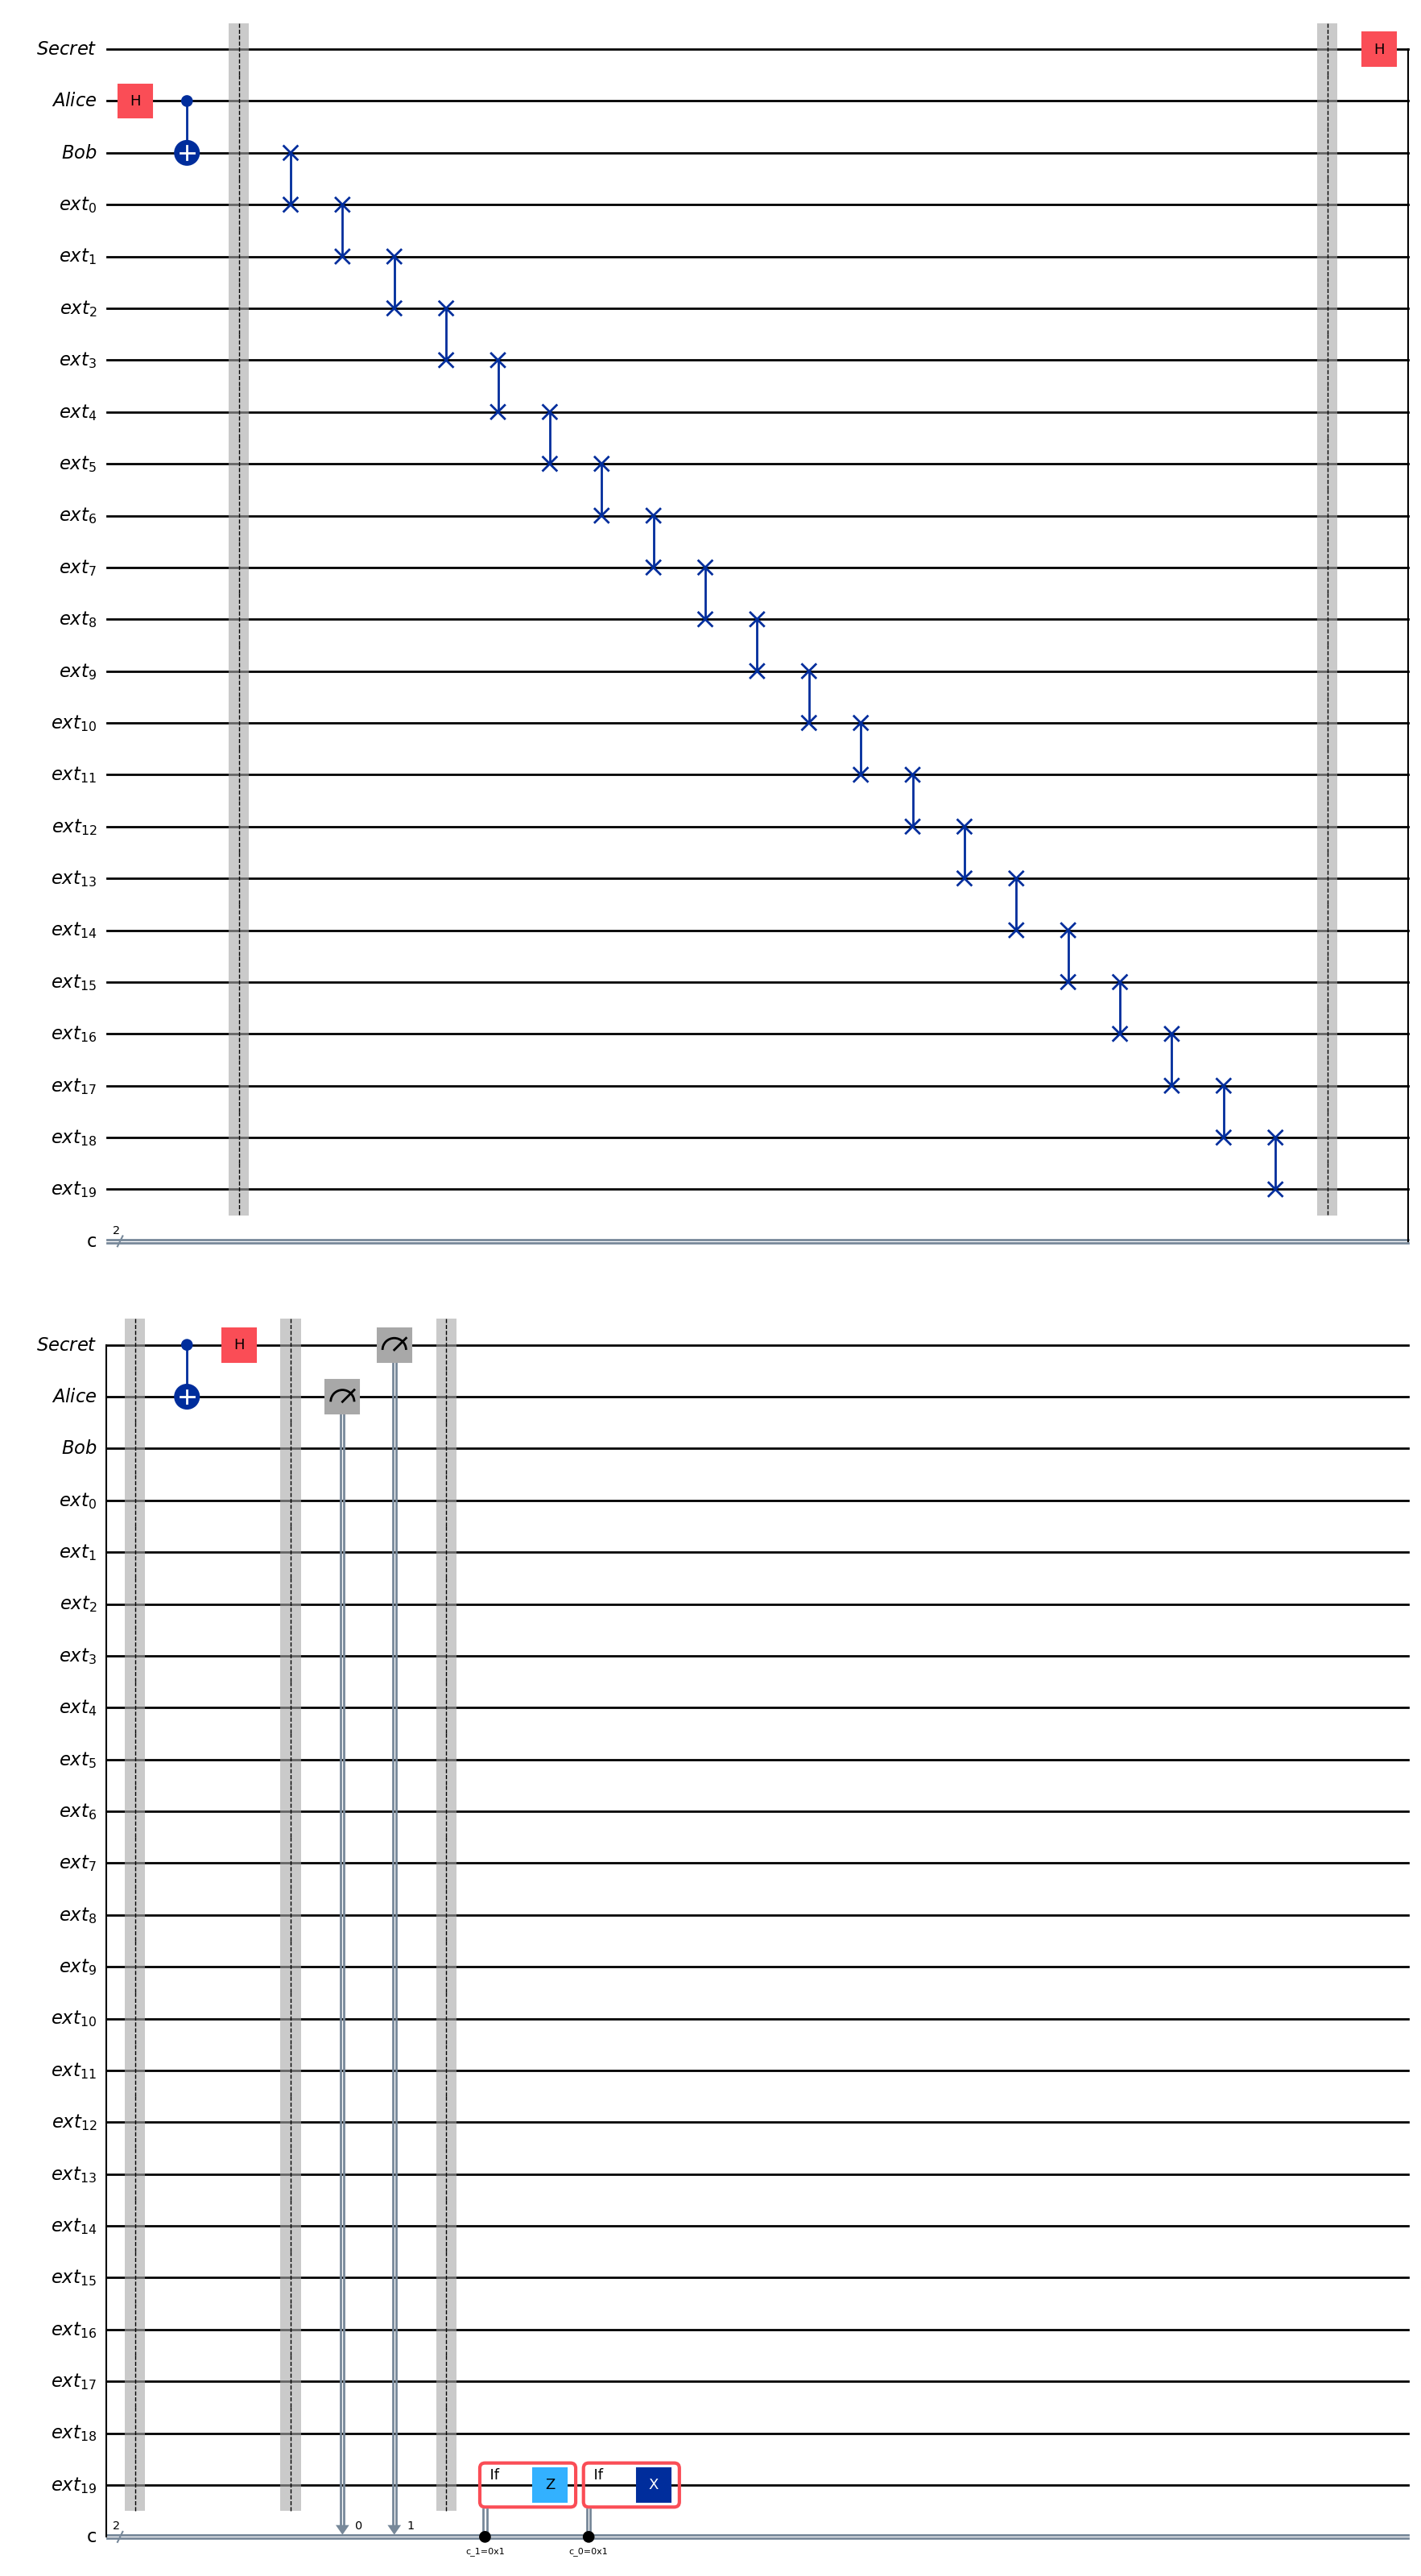

In [5]:
circuit.draw('mpl')